# CRIAÇÃO DO AMBIENTE E ORGANIZAÇÃO 

In [1464]:
import findspark
import pyspark
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import *
from pyspark.sql.functions import to_date, col, coalesce, date_format, current_date, datediff, floor, when, corr, row_number, lower, upper, avg, stddev, percentile_approx, expr, max, min
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window

In [1465]:
# Inicializa o SparkSession
spark = SparkSession.builder \
    .appName("ExemploSpark") \
    .getOrCreate()

# Verifica a versão do Spark para confirmar a configuração
print("Versão do Spark:", spark.version)


Versão do Spark: 3.5.2


24/08/29 11:47:37 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [1466]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"
# Torna o pyspark "importável"
findspark.init()

In [1467]:
# Crie uma sessão do Spark
spark = SparkSession.builder.appName("DataCleaning").getOrCreate()

# Carregar o DataFrame de um arquivo CSV
df_cleaned = spark.read.csv("/home/wermelingerv/Documentos/GitHub/SoulCode/Bootcamp - ANALISE DE DADOS/Banco de Dados_base_suja.csv", header=True, inferSchema=True)

df_cleaned.show()

24/08/29 11:47:37 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


+---+--------------+-----+----------+-------+-------------------+-----------------+
| ID|          Nome|Idade|      Área|Salário|Data de Contratação|Status de Emprego|
+---+--------------+-----+----------+-------+-------------------+-----------------+
|  1|    João Silva|   29|Financeiro|   5500|         01/02/2020|            Ativo|
|  2|   Maria Souza|   30|        RH|   4800|         15-03-2019|            ativo|
|  3|Carlos Pereira| NULL| Finaceiro|   6200|         2020/04/01|            Ativo|
|  4|     Ana Clara|   27| Marketing|   4800|         12/06/2018|            Ativo|
|  5|  Fabio Santos|   31|      NULL|   5500|         20-11-2017|            ativo|
|  6|   Sandra Lima|   28|        RH|   NULL|         05-05-2020|            Ativo|
|  7|    José Alves|   34| Marketing|   5400|         2018/02/01|          inativo|
|  8| Luciana Costa|   30|Financeiro|R$ 5200|         01.01.2019|            Ativo|
|  9| Paulo Ricardo| NULL| Finaceiro|   6100|         12/12/2020|          I

In [1468]:
# Substituir valores nulos na coluna 'Data de Contratação' pela data atual
df_cleaned = df_cleaned.withColumn(
    "Data de Contratação",
    when(col("Data de Contratação").isNull(), current_date()).otherwise(col("Data de Contratação")))
df_cleaned.show()

+---+--------------+-----+----------+-------+-------------------+-----------------+
| ID|          Nome|Idade|      Área|Salário|Data de Contratação|Status de Emprego|
+---+--------------+-----+----------+-------+-------------------+-----------------+
|  1|    João Silva|   29|Financeiro|   5500|         01/02/2020|            Ativo|
|  2|   Maria Souza|   30|        RH|   4800|         15-03-2019|            ativo|
|  3|Carlos Pereira| NULL| Finaceiro|   6200|         2020/04/01|            Ativo|
|  4|     Ana Clara|   27| Marketing|   4800|         12/06/2018|            Ativo|
|  5|  Fabio Santos|   31|      NULL|   5500|         20-11-2017|            ativo|
|  6|   Sandra Lima|   28|        RH|   NULL|         05-05-2020|            Ativo|
|  7|    José Alves|   34| Marketing|   5400|         2018/02/01|          inativo|
|  8| Luciana Costa|   30|Financeiro|R$ 5200|         01.01.2019|            Ativo|
|  9| Paulo Ricardo| NULL| Finaceiro|   6100|         12/12/2020|          I

In [1469]:
# Converter diferentes formatos para o formato padrão yyyy-MM-dd
df_cleaned = df_cleaned.withColumn(
    "Data de Contratação",
    coalesce(
        to_date(col("Data de Contratação"), "dd/MM/yyyy"),
        to_date(col("Data de Contratação"), "dd-MM-yyyy"),
        to_date(col("Data de Contratação"), "yyyy/MM/dd"),
        to_date(col("Data de Contratação"), "yyyy-MM-dd"),
        to_date(col("Data de Contratação"), "dd.MM.yyyy")))

# Formatar a data para o formato dd/MM/yyyy
df_cleaned = df_cleaned.withColumn("Data de Contratação", date_format(col("Data de Contratação"), "dd/MM/yyyy"))

# Mostrar o DataFrame formatado
df_cleaned.show(truncate=False)

+---+--------------+-----+----------+-------+-------------------+-----------------+
|ID |Nome          |Idade|Área      |Salário|Data de Contratação|Status de Emprego|
+---+--------------+-----+----------+-------+-------------------+-----------------+
|1  |João Silva    |29   |Financeiro|5500   |01/02/2020         |Ativo            |
|2  |Maria Souza   |30   |RH        |4800   |15/03/2019         |ativo            |
|3  |Carlos Pereira|NULL |Finaceiro |6200   |01/04/2020         |Ativo            |
|4  |Ana Clara     |27   |Marketing |4800   |12/06/2018         |Ativo            |
|5  |Fabio Santos  |31   |NULL      |5500   |20/11/2017         |ativo            |
|6  |Sandra Lima   |28   |RH        |NULL   |05/05/2020         |Ativo            |
|7  |José Alves    |34   |Marketing |5400   |01/02/2018         |inativo          |
|8  |Luciana Costa |30   |Financeiro|R$ 5200|01/01/2019         |Ativo            |
|9  |Paulo Ricardo |NULL |Finaceiro |6100   |12/12/2020         |Inativo    

In [1470]:
# Tirar os duplicados 
df_cleaned = df_cleaned.dropDuplicates()
df_cleaned.show()

# Substituir valores nulos na coluna 'idade' por 0
#df_cleaned = df_cleaned.fillna({'idade': 0})
#df_cleaned.show()

+---+--------------+-----+----------+-------+-------------------+-----------------+
| ID|          Nome|Idade|      Área|Salário|Data de Contratação|Status de Emprego|
+---+--------------+-----+----------+-------+-------------------+-----------------+
|  1|    João Silva|   29|Financeiro|   5500|         01/02/2020|            Ativo|
|  2|   Maria Souza|   30|        RH|   4800|         15/03/2019|            ativo|
|  4|     Ana Clara|   27| Marketing|   4800|         12/06/2018|            Ativo|
|  8| Luciana Costa|   30|Financeiro|R$ 5200|         01/01/2019|            Ativo|
| 10| Fernanda Dias|   29|        RH|   4800|         29/08/2024|            Ativo|
|  7|    José Alves|   34| Marketing|   5400|         01/02/2018|          inativo|
|  9| Paulo Ricardo| NULL| Finaceiro|   6100|         12/12/2020|          Inativo|
|  6|   Sandra Lima|   28|        RH|   NULL|         05/05/2020|            Ativo|
|  3|Carlos Pereira| NULL| Finaceiro|   6200|         01/04/2020|           

In [1471]:
# Verifique se o nome da coluna é 'Salário' ou 'Salario' e renomeie se necessário
if 'Salário' in df_cleaned.columns:
    df_cleaned = df_cleaned.withColumnRenamed("Salário", "Salario")

# Limpar e normalizar a coluna 'Salario'
df_cleaned = df_cleaned.withColumn("Salario", regexp_replace(col("Salario"), "R\\$", ""))  # Remove prefixo R$
df_cleaned = df_cleaned.withColumn("Salario", regexp_replace(col("Salario"), "\\s+", ""))  # Remove espaços
df_cleaned = df_cleaned.withColumn("Salario", col("Salario").cast("double"))  # Converte para double

# Calcular a média dos valores não nulos em 'Salario'
mean_salary = df_cleaned.select(mean(col("Salario"))).collect()[0][0]

# Substituir valores nulos em 'Salario' com a média
df_cleaned = df_cleaned.withColumn("Salario", 
                                   when(col("Salario").isNull(), mean_salary)
                                   .otherwise(col("Salario")))

# Mostrar o DataFrame atualizado
df_cleaned.show(truncate=False)

+---+--------------+-----+----------+-----------------+-------------------+-----------------+
|ID |Nome          |Idade|Área      |Salario          |Data de Contratação|Status de Emprego|
+---+--------------+-----+----------+-----------------+-------------------+-----------------+
|1  |João Silva    |29   |Financeiro|5500.0           |01/02/2020         |Ativo            |
|2  |Maria Souza   |30   |RH        |4800.0           |15/03/2019         |ativo            |
|4  |Ana Clara     |27   |Marketing |4800.0           |12/06/2018         |Ativo            |
|8  |Luciana Costa |30   |Financeiro|5200.0           |01/01/2019         |Ativo            |
|10 |Fernanda Dias |29   |RH        |4800.0           |29/08/2024         |Ativo            |
|7  |José Alves    |34   |Marketing |5400.0           |01/02/2018         |inativo          |
|9  |Paulo Ricardo |NULL |Finaceiro |6100.0           |12/12/2020         |Inativo          |
|6  |Sandra Lima   |28   |RH        |5366.666666666667|05/05

In [1472]:
# Substituir valores nulos por "Desconhecida"
df_cleaned = df_cleaned.withColumn("Área", when(col("Área").isNull(), "Desconhecido").otherwise(col("Área")))


# Corrigir inconsistências de maiúsculas e minúsculas na coluna 'Área'
df_cleaned = df_cleaned.withColumn("Área", lower(col("Área")))


# Corrigir inconsistências de maiúsculas e minúsculas na coluna 'Status de Emprego'
df_cleaned = df_cleaned.withColumn("Status de Emprego", lower(col("Status de Emprego")))

# Corrigir variações na coluna 'Área'
df_cleaned = df_cleaned.withColumn("Área", 
    when(col("Área").like("finaceiro") | col("Área").like("financiero") | col("Área").like("financ"), "financeiro")
    .otherwise(col("Área"))
)

# Exibir o DataFrame resultante
df_cleaned.show(truncate=False)


# Exibir o DataFrame resultante
df_cleaned.show()

+---+--------------+-----+------------+-----------------+-------------------+-----------------+
|ID |Nome          |Idade|Área        |Salario          |Data de Contratação|Status de Emprego|
+---+--------------+-----+------------+-----------------+-------------------+-----------------+
|1  |João Silva    |29   |financeiro  |5500.0           |01/02/2020         |ativo            |
|2  |Maria Souza   |30   |rh          |4800.0           |15/03/2019         |ativo            |
|4  |Ana Clara     |27   |marketing   |4800.0           |12/06/2018         |ativo            |
|8  |Luciana Costa |30   |financeiro  |5200.0           |01/01/2019         |ativo            |
|10 |Fernanda Dias |29   |rh          |4800.0           |29/08/2024         |ativo            |
|7  |José Alves    |34   |marketing   |5400.0           |01/02/2018         |inativo          |
|9  |Paulo Ricardo |NULL |financeiro  |6100.0           |12/12/2020         |inativo          |
|6  |Sandra Lima   |28   |rh          |5

In [1473]:
df_cleaned.columns

['ID',
 'Nome',
 'Idade',
 'Área',
 'Salario',
 'Data de Contratação',
 'Status de Emprego']

In [1474]:
df_cleaned.show()

+---+--------------+-----+------------+-----------------+-------------------+-----------------+
| ID|          Nome|Idade|        Área|          Salario|Data de Contratação|Status de Emprego|
+---+--------------+-----+------------+-----------------+-------------------+-----------------+
|  1|    João Silva|   29|  financeiro|           5500.0|         01/02/2020|            ativo|
|  2|   Maria Souza|   30|          rh|           4800.0|         15/03/2019|            ativo|
|  4|     Ana Clara|   27|   marketing|           4800.0|         12/06/2018|            ativo|
|  8| Luciana Costa|   30|  financeiro|           5200.0|         01/01/2019|            ativo|
| 10| Fernanda Dias|   29|          rh|           4800.0|         29/08/2024|            ativo|
|  7|    José Alves|   34|   marketing|           5400.0|         01/02/2018|          inativo|
|  9| Paulo Ricardo| NULL|  financeiro|           6100.0|         12/12/2020|          inativo|
|  6|   Sandra Lima|   28|          rh|5

# COMEÇO 

In [1475]:
#1. Análise de Consistência de Dados: Identificar e corrigir inconsistências nos valores de Área e Status de Emprego (e.g., diferenças de maiúsculas/minúsculas).
# Renomear a coluna "Área" para "Area"
df_cleaned = df_cleaned.withColumnRenamed("Área", "Area")

# Converter as colunas para minúsculas
df_cleaned = df_cleaned.withColumn("Area", lower(df_cleaned["Area"])) \
                       .withColumn("Status de Emprego", lower(df_cleaned["Status de Emprego"]))

# Mostrar o resultado
df_cleaned.show()

+---+--------------+-----+------------+-----------------+-------------------+-----------------+
| ID|          Nome|Idade|        Area|          Salario|Data de Contratação|Status de Emprego|
+---+--------------+-----+------------+-----------------+-------------------+-----------------+
|  1|    João Silva|   29|  financeiro|           5500.0|         01/02/2020|            ativo|
|  2|   Maria Souza|   30|          rh|           4800.0|         15/03/2019|            ativo|
|  4|     Ana Clara|   27|   marketing|           4800.0|         12/06/2018|            ativo|
|  8| Luciana Costa|   30|  financeiro|           5200.0|         01/01/2019|            ativo|
| 10| Fernanda Dias|   29|          rh|           4800.0|         29/08/2024|            ativo|
|  7|    José Alves|   34|   marketing|           5400.0|         01/02/2018|          inativo|
|  9| Paulo Ricardo| NULL|  financeiro|           6100.0|         12/12/2020|          inativo|
|  6|   Sandra Lima|   28|          rh|5

In [1476]:
#2. Limpeza de Dados Faltantes: Detectar e tratar os valores ausentes na coluna Idade e Área.
# nulos existem nas colunas "Idade" e "Área"
df_cleaned.select([count(when(col(c).isNull() | isnan(c), c)).alias(c) for c in ["Idade", "Area"]]).show()

# Calcular a média da coluna "Idade"
media_idade = df_cleaned.select(avg(col("Idade"))).first()[0]

# Substituir valores nulos pela média na coluna "Idade"
df_cleaned = df_cleaned.withColumn(
    "Idade",
    when(col("Idade").isNull(), media_idade).otherwise(col("Idade")))
# Mostrar o DataFrame atualizado
df_cleaned.show()

+-----+----+
|Idade|Area|
+-----+----+
|    2|   0|
+-----+----+

+---+--------------+-----+------------+-----------------+-------------------+-----------------+
| ID|          Nome|Idade|        Area|          Salario|Data de Contratação|Status de Emprego|
+---+--------------+-----+------------+-----------------+-------------------+-----------------+
|  1|    João Silva| 29.0|  financeiro|           5500.0|         01/02/2020|            ativo|
|  2|   Maria Souza| 30.0|          rh|           4800.0|         15/03/2019|            ativo|
|  4|     Ana Clara| 27.0|   marketing|           4800.0|         12/06/2018|            ativo|
|  8| Luciana Costa| 30.0|  financeiro|           5200.0|         01/01/2019|            ativo|
| 10| Fernanda Dias| 29.0|          rh|           4800.0|         29/08/2024|            ativo|
|  7|    José Alves| 34.0|   marketing|           5400.0|         01/02/2018|          inativo|
|  9| Paulo Ricardo|29.75|  financeiro|           6100.0|         12/1

In [1477]:
# 3. Analisar a distribuição da idade dos funcionários por departamento

média= df_cleaned.groupBy("Area").agg(
        avg("Idade").alias("Média de Idade"),
        stddev("Idade").alias("Desvio Padrão de Idade"),
        count("Idade").alias("Contagem de Funcionários"))

# Mostrar o resultado da análise de distribuição de idade por departamento
média.show()

# valor 0.0 para o desvio padrão na área "financeiro" indica que todos os valores de idade para essa área são iguais.
# NULL no valor do "Desvio Padrão de Idade" para a área "desconhecida" ocorre porque o cálculo do desvio padrão exige pelo menos dois valores distintos na amostra para produzir um resultado válido.
# Análse: No financeiro temos à média de idade de 29 anos, markenting 30 anos e rh de 29 anos. Temos um desconhecido onde tem 31 anos.

+------------+--------------+----------------------+------------------------+
|        Area|Média de Idade|Desvio Padrão de Idade|Contagem de Funcionários|
+------------+--------------+----------------------+------------------------+
|desconhecido|          31.0|                  NULL|                       1|
|  financeiro|        29.625|    0.4330127018922194|                       4|
|   marketing|          30.5|     4.949747468305833|                       2|
|          rh|          29.0|                   1.0|                       3|
+------------+--------------+----------------------+------------------------+



In [1478]:
# 4.Salário por Departamento: Calcular a média, mediana e desvio padrão dos salários por departamento.
# Calcular a média, mediana e desvio padrão dos salários por departamento
calculo_medio = df_cleaned.groupBy("Area").agg(
    avg("Salario").alias("Media Salario"),
    percentile_approx("Salario", 0.5).alias("Mediana Salario"),
    stddev("Salario").alias("Desvio Padrao Salario")
)
calculo_medio.show()


# Desconhcido nãp pode ser avaliado (tem um funcionario que não tem departamento)
# NULL no valor do "Desvio Padrão de Idade" para a área "desconhecida" ocorre porque o cálculo do desvio padrão exige pelo menos dois valores distintos na amostra para produzir um resultado válido.
# Análise há maior média e do serto financeiro, seguindo com marketing e rh

+------------+----------------+---------------+---------------------+
|        Area|   Media Salario|Mediana Salario|Desvio Padrao Salario|
+------------+----------------+---------------+---------------------+
|desconhecido|          5500.0|         5500.0|                 NULL|
|  financeiro|          5750.0|         5500.0|   479.58315233127195|
|   marketing|          5100.0|         4800.0|   424.26406871192853|
|          rh|4988.88888888889|         4800.0|    327.1651525407881|
+------------+----------------+---------------+---------------------+



In [1479]:
#5. Análise de Outliers: Identificar salários que estão fora do padrão (outliers) para cada departamento.
# Verifique se não há valores nulos na coluna 'Salario' e 'Area'
df_cleaned = df_cleaned.dropna(subset=['Salario', 'Area'])

# Calcular os quantis Q1 e Q3
df_stats = df_cleaned.groupBy("Area").agg(
    expr("percentile_approx(Salario, 0.25)").alias("Q1"),
    expr("percentile_approx(Salario, 0.75)").alias("Q3")
)

# Verificar se os valores de Q1 e Q3 foram calculados corretamente
df_stats.show()

# Calcular o IQR (Q3 - Q1)
df_stats = df_stats.withColumn("IQR", col("Q3") - col("Q1"))

# Determinar os limites inferior e superior para detectar outliers
df_stats = df_stats.withColumn("Limite Inferior", col("Q1") - 1.5 * col("IQR"))\
                   .withColumn("Limite Superior", col("Q3") + 1.5 * col("IQR"))

# Verificar se os limites foram calculados corretamente
df_stats.show()

# Juntar os limites calculados com o dataframe original para identificar os outliers
df_cleaned = df_cleaned.join(df_stats, on="Area", how='left')

# Verificar se a junção foi realizada corretamente e se os limites não são nulos
df_cleaned.show()

# Filtrar os outliers (salários fora dos limites inferior e superior)
df_outliers = df_cleaned.filter(
    (col("Salario") < col("Limite Inferior")) | (col("Salario") > col("Limite Superior"))
)

# Mostrar os outliers identificados
df_outliers.select("Area", "Salario", "Limite Inferior", "Limite Superior").show()

## NÃO HOUVE RETORNO POIS TINHA CAMPO NULL ONDE FOI PREENCHIDO COM A MÉDIA SALÁRIO DOS OUTRO

+------------+------+-----------------+
|        Area|    Q1|               Q3|
+------------+------+-----------------+
|desconhecido|5500.0|           5500.0|
|  financeiro|5200.0|           6100.0|
|   marketing|4800.0|           5400.0|
|          rh|4800.0|5366.666666666667|
+------------+------+-----------------+

+------------+------+-----------------+----------------+------------------+-----------------+
|        Area|    Q1|               Q3|             IQR|   Limite Inferior|  Limite Superior|
+------------+------+-----------------+----------------+------------------+-----------------+
|desconhecido|5500.0|           5500.0|             0.0|            5500.0|           5500.0|
|  financeiro|5200.0|           6100.0|           900.0|            3850.0|           7450.0|
|   marketing|4800.0|           5400.0|           600.0|            3900.0|           6300.0|
|          rh|4800.0|5366.666666666667|566.666666666667|3949.9999999999995|6216.666666666668|
+------------+------+

In [1480]:
#6. Correlação Idade-Salário: Analisar a correlação entre idade e salário dos funcionários.

# Calcule a correlação entre 'Idade' e 'Salario'
correlation = df_cleaned.corr('Idade', 'Salario')
print(" 1 indica uma correlação positiva perfeita/ -1 indica uma correlação negativa perfeita/ 0 indica nenhuma correlação linear.")
print(f'A correlação de idade e salário."{correlation}" - 0 indica nenhuma correlação linear.')


corr_result = df_cleaned.select(corr("Idade", "Salario").alias("Correlação Idade-Salário"))
corr_result.show()
# Análise: 0 indica nenhuma correlação linear.

 1 indica uma correlação positiva perfeita/ -1 indica uma correlação negativa perfeita/ 0 indica nenhuma correlação linear.
A correlação de idade e salário."0.2380270422540022" - 0 indica nenhuma correlação linear.
+------------------------+
|Correlação Idade-Salário|
+------------------------+
|      0.2380270422540022|
+------------------------+



In [1481]:
#7. Tempo de Casa: Calcular o tempo de contratação dos funcionários e categorizá-los em grupos(e.g., 1-3 anos, 4-6 anos, etc.).
# Converter a coluna "Data de Contratação" para o formato yyyy-MM-dd
df_cleaned = df_cleaned.withColumn(
    "Data de Contratação",
    to_date(col("Data de Contratação"), "dd/MM/yyyy"))

# Calcular a diferença em dias entre a data atual e a data de contratação
df_cleaned = df_cleaned.withColumn(
    "Dias de Casa", datediff(current_date(), col("Data de Contratação")))

# Converter dias para anos e criar a nova coluna
df_cleaned = df_cleaned.withColumn(
    "Tempo de Casa", floor(col("Dias de Casa") / 365.25))

# Categorizar o tempo de casa
df_cleaned = df_cleaned.withColumn(
    "Categoria De Tempo de Casa",
    when(col("Tempo de Casa") <= 3, "01 - 03 anos")
    .when((col("Tempo de Casa") > 3) & (col("Tempo de Casa") <= 6), "04 - 06 anos")
    .when((col("Tempo de Casa") > 6) & (col("Tempo de Casa") <= 10), "06 - 10 anos")
    .otherwise("Mais de 10 anos"))

# Mostrar o DataFrame
df_cleaned.show() 

#Análise: Maior parte da equipe trabalha de 4 à 6 anos

+------------+---+--------------+-----+-----------------+-------------------+-----------------+------+-----------------+----------------+------------------+-----------------+------------+-------------+--------------------------+
|        Area| ID|          Nome|Idade|          Salario|Data de Contratação|Status de Emprego|    Q1|               Q3|             IQR|   Limite Inferior|  Limite Superior|Dias de Casa|Tempo de Casa|Categoria De Tempo de Casa|
+------------+---+--------------+-----+-----------------+-------------------+-----------------+------+-----------------+----------------+------------------+-----------------+------------+-------------+--------------------------+
|  financeiro|  1|    João Silva| 29.0|           5500.0|         2020-02-01|            ativo|5200.0|           6100.0|           900.0|            3850.0|           7450.0|        1671|            4|              04 - 06 anos|
|          rh|  2|   Maria Souza| 30.0|           4800.0|         2019-03-15|       

In [1482]:
#8. Análise de Rotatividade: Identificar padrões entre os funcionários que estão ativos versus os que não estão.
# Resumo Estatístico para Funcionários Ativos e Inativos
df_rotatividade = df_cleaned.groupBy("Status de Emprego").agg(
    avg("Idade").alias("Média de Idade"),
    stddev("Idade").alias("Desvio Padrão de Idade"),
    avg("Salario").alias("Média de Salário"),
    stddev("Salario").alias("Desvio Padrão de Salário"),
    count("ID").alias("Contagem de Funcionários"))
df_rotatividade.show()

# Contagem de Funcionários Ativos e Inativos por Departamento
df_dep_rotatividade = df_cleaned.groupBy("Area", "Status de Emprego").count()
df_dep_rotatividade.show()

# Distribuição do Tempo de Casa por Status de Emprego
df_time_casa_distribution = df_cleaned.groupBy("Status de Emprego").agg(
    avg("Tempo de Casa").alias("Média de Tempo de Casa"),
    stddev("Tempo de Casa").alias("Desvio Padrão de Tempo de Casa"),
    count("ID").alias("Contagem de Funcionários"))

df_time_casa_distribution.show() 

+-----------------+--------------+----------------------+-----------------+------------------------+------------------------+
|Status de Emprego|Média de Idade|Desvio Padrão de Idade| Média de Salário|Desvio Padrão de Salário|Contagem de Funcionários|
+-----------------+--------------+----------------------+-----------------+------------------------+------------------------+
|            ativo|      29.21875|    1.2637635120091557|5270.833333333334|      485.15665936580143|                       8|
|          inativo|        31.875|     3.005203820042827|           5750.0|       494.9747468305833|                       2|
+-----------------+--------------+----------------------+-----------------+------------------------+------------------------+

+------------+-----------------+-----+
|        Area|Status de Emprego|count|
+------------+-----------------+-----+
|desconhecido|            ativo|    1|
|  financeiro|          inativo|    1|
|   marketing|          inativo|    1|
|  financ

In [1483]:
# 8. continuação
# Estatísticas de Salário por Status de Emprego
df_salary_analysis = df_cleaned.groupBy("Status de Emprego").agg(
    avg("Salario").alias("Média de Salário"),
    stddev("Salario").alias("Desvio Padrão de Salário"),
    count("ID").alias("Contagem de Funcionários"))

df_salary_analysis.show()

# Calcular a correlação entre idade e salário para funcionários ativos e inativos
df_corr_analysis = df_cleaned.groupBy("Status de Emprego").agg(
    corr("Idade", "Salario").alias("Correlação Idade-Salário"))

df_corr_analysis.show() 

#Análise: temos uma relação bem similar em vários aspectos calculados, apesar de inativos representar 20% da lista de ativos. 

+-----------------+-----------------+------------------------+------------------------+
|Status de Emprego| Média de Salário|Desvio Padrão de Salário|Contagem de Funcionários|
+-----------------+-----------------+------------------------+------------------------+
|            ativo|5270.833333333334|      485.15665936580143|                       8|
|          inativo|           5750.0|       494.9747468305833|                       2|
+-----------------+-----------------+------------------------+------------------------+

+-----------------+------------------------+
|Status de Emprego|Correlação Idade-Salário|
+-----------------+------------------------+
|            ativo|      0.3400329891143649|
|          inativo|                    -1.0|
+-----------------+------------------------+



In [1484]:
# 9. Análise de Desempenho por Data de Contratação: Verificar se existe uma correlação entre o ano de contratação e o nível de salário.
# Converter a coluna 'Data de Contratação' para o tipo Date e extrair o ano
df_cleaned = df_cleaned.withColumn("Ano de Contratação", year(to_date(col("Data de Contratação"), "dd/MM/yyyy")))

# Calcular a correlação entre 'Ano de Contratação' e 'Salario'
correlation = df_cleaned.stat.corr("Ano de Contratação", "Salario")

print("1 indica uma correlação positiva perfeita. / -1 indica uma correlação negativa perfeita. / 0 indica nenhuma correlação linear.")
print(f"Correlação entre o ano de contratação e o nível de salário: '{correlation}' 0 indica nenhuma correlação linear.")

1 indica uma correlação positiva perfeita. / -1 indica uma correlação negativa perfeita. / 0 indica nenhuma correlação linear.
Correlação entre o ano de contratação e o nível de salário: '-0.10112445480149997' 0 indica nenhuma correlação linear.


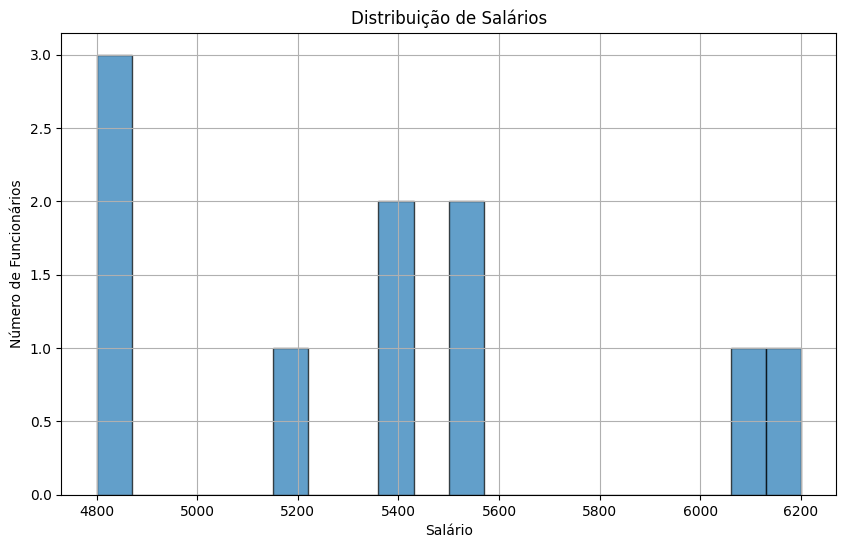

In [1485]:
# 10. Histograma de Salário: Criar um histograma de salários para visualizar a distribuição geral.
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

# Obter os dados de salário como uma lista
salarios = df_cleaned.select("Salario").rdd.flatMap(lambda x: x).collect()

# Criar o histograma com matplotlib
plt.figure(figsize=(10, 6))
plt.hist(salarios, bins=20, edgecolor='k', alpha=0.7)
plt.title('Distribuição de Salários')
plt.xlabel('Salário')
plt.ylabel('Número de Funcionários')
plt.grid(True)
plt.show()

In [1486]:
#11. Análise de Frequência: Quantificar a frequência dos nomes dos funcionários para identificar nomes comuns.
# Agrupar por 'Nome' e contar a frequência de cada nome
df_name_frequency = df_cleaned.groupBy("Nome").agg(count("Nome").alias("Frequência"))
# Ordenar por frequência em ordem decrescente
df_name_frequency = df_name_frequency.orderBy(col("Frequência").desc())
# Mostrar o resultado
df_name_frequency.show()

# Temos a frequência de nomes permanece em 1, pós não ser repetem.

+--------------+----------+
|          Nome|Frequência|
+--------------+----------+
|     Ana Clara|         1|
| Paulo Ricardo|         1|
| Fernanda Dias|         1|
|   Sandra Lima|         1|
|    José Alves|         1|
| Luciana Costa|         1|
|  Fabio Santos|         1|
|Carlos Pereira|         1|
|    João Silva|         1|
|   Maria Souza|         1|
+--------------+----------+



In [1487]:
#12. Agrupamento de Departamentos: Analisar o impacto do departamento na variação salarial e na distribuição de idade.
# Agrupar por 'Area' e calcular as estatísticas salariais
df_salary_stats = df_cleaned.groupBy("Area").agg(
    avg("Salario").alias("Média Salarial"),
    stddev("Salario").alias("Desvio Padrão Salarial"),
    expr("percentile_approx(Salario, 0.25)").alias("Q1"),
    expr("percentile_approx(Salario, 0.75)").alias("Q3"))

df_salary_stats.show()

# Agrupar por 'Area' e calcular as estatísticas da idade
df_age_stats = df_cleaned.groupBy("Area").agg(
    mean("Idade").alias("Média Idade"),
    stddev("Idade").alias("Desvio Padrão Idade"),
    min("Idade").alias("Idade Mínima"),
    max("Idade").alias("Idade Máxima"))

df_age_stats.show()


+------------+----------------+----------------------+------+-----------------+
|        Area|  Média Salarial|Desvio Padrão Salarial|    Q1|               Q3|
+------------+----------------+----------------------+------+-----------------+
|desconhecido|          5500.0|                  NULL|5500.0|           5500.0|
|  financeiro|          5750.0|    479.58315233127195|5200.0|           6100.0|
|   marketing|          5100.0|    424.26406871192853|4800.0|           5400.0|
|          rh|4988.88888888889|     327.1651525407881|4800.0|5366.666666666667|
+------------+----------------+----------------------+------+-----------------+

+------------+-----------+-------------------+------------+------------+
|        Area|Média Idade|Desvio Padrão Idade|Idade Mínima|Idade Máxima|
+------------+-----------+-------------------+------------+------------+
|desconhecido|       31.0|               NULL|        31.0|        31.0|
|  financeiro|     29.625| 0.4330127018922194|        29.0|        

In [1488]:
#13. Normalização de Dados: Normalizar o salário e idade para comparações entre diferentes departamentos.
# Calcular valores mínimo e máximo para normalização
sal_min = df_cleaned.agg(min("Salario")).collect()[0][0]
sal_max = df_cleaned.agg(max("Salario")).collect()[0][0]
idade_min = df_cleaned.agg(min("Idade")).collect()[0][0]
idade_max = df_cleaned.agg(max("Idade")).collect()[0][0]

# Normalizar salário e idade
df_normal = df_cleaned.withColumn("Salario Normalizado",
    (col("Salario") - sal_min) / (sal_max - sal_min)).withColumn("Idade Normalizada",
    (col("Idade") - idade_min) / (idade_max - idade_min))
df_normal.show()

# Calcular média e desvio padrão para padronização
sal_mean = df_cleaned.agg(mean("Salario")).collect()[0][0]
sal_stddev = df_cleaned.agg(stddev("Salario")).collect()[0][0]
idade_mean = df_cleaned.agg(mean("Idade")).collect()[0][0]
idade_stddev = df_cleaned.agg(stddev("Idade")).collect()[0][0]

# Padronizar salário e idade
df_stand = df_cleaned.withColumn("Salario Padronizado",
    (col("Salario") - sal_mean) / sal_stddev).withColumn("Idade Padronizada",
    (col("Idade") - idade_mean) / idade_stddev)

df_stand.show()


+------------+---+--------------+-----+-----------------+-------------------+-----------------+------+-----------------+----------------+------------------+-----------------+------------+-------------+--------------------------+------------------+-------------------+-------------------+
|        Area| ID|          Nome|Idade|          Salario|Data de Contratação|Status de Emprego|    Q1|               Q3|             IQR|   Limite Inferior|  Limite Superior|Dias de Casa|Tempo de Casa|Categoria De Tempo de Casa|Ano de Contratação|Salario Normalizado|  Idade Normalizada|
+------------+---+--------------+-----+-----------------+-------------------+-----------------+------+-----------------+----------------+------------------+-----------------+------------+-------------+--------------------------+------------------+-------------------+-------------------+
|  financeiro|  1|    João Silva| 29.0|           5500.0|         2020-02-01|            ativo|5200.0|           6100.0|           900.0

In [1489]:
#14. Proporção de Gêneros: Analisar a proporção de gêneros entre os funcionários, caso houvesse uma coluna de gênero.
df_cleaned = df_cleaned.withColumn("Genero", when(col("ID") % 2 == 0, "Feminino").otherwise("Masculino"))
df_cleaned.show()

# Contar o número de funcionários por gênero
contagem_genero = df_cleaned.groupBy("Genero").agg(count("ID").alias("Quantidade"))
# Calcular o total de funcionários
total_funcionarios = df_cleaned.count()

# Calcular a proporção de cada gênero
proporcao_genero = contagem_genero.withColumn("Proporcao", col("Quantidade") / total_funcionarios)
proporcao_genero.show() 

#Análise: proporção de homem e mulheres e de 50 % para ambos.

+------------+---+--------------+-----+-----------------+-------------------+-----------------+------+-----------------+----------------+------------------+-----------------+------------+-------------+--------------------------+------------------+---------+
|        Area| ID|          Nome|Idade|          Salario|Data de Contratação|Status de Emprego|    Q1|               Q3|             IQR|   Limite Inferior|  Limite Superior|Dias de Casa|Tempo de Casa|Categoria De Tempo de Casa|Ano de Contratação|   Genero|
+------------+---+--------------+-----+-----------------+-------------------+-----------------+------+-----------------+----------------+------------------+-----------------+------------+-------------+--------------------------+------------------+---------+
|  financeiro|  1|    João Silva| 29.0|           5500.0|         2020-02-01|            ativo|5200.0|           6100.0|           900.0|            3850.0|           7450.0|        1671|            4|              04 - 06 ano

In [1490]:
#15. Correção de Formato de Data: Uniformizar o formato das datas de contratação.
## resolvido na limpeza e organização do df_cleaned

df_cleaned.show()

+------------+---+--------------+-----+-----------------+-------------------+-----------------+------+-----------------+----------------+------------------+-----------------+------------+-------------+--------------------------+------------------+---------+
|        Area| ID|          Nome|Idade|          Salario|Data de Contratação|Status de Emprego|    Q1|               Q3|             IQR|   Limite Inferior|  Limite Superior|Dias de Casa|Tempo de Casa|Categoria De Tempo de Casa|Ano de Contratação|   Genero|
+------------+---+--------------+-----+-----------------+-------------------+-----------------+------+-----------------+----------------+------------------+-----------------+------------+-------------+--------------------------+------------------+---------+
|  financeiro|  1|    João Silva| 29.0|           5500.0|         2020-02-01|            ativo|5200.0|           6100.0|           900.0|            3850.0|           7450.0|        1671|            4|              04 - 06 ano

In [1491]:
#16. Impacto de Status no Salário: Comparar salários médios entre funcionários ativos e não ativos.
# Calcular a média de salário por status de emprego
resultado = df_cleaned.groupBy("Status de Emprego").agg(avg("Salario").alias("Salario Medio"))
resultado.show()

+-----------------+-----------------+
|Status de Emprego|    Salario Medio|
+-----------------+-----------------+
|            ativo|5270.833333333334|
|          inativo|           5750.0|
+-----------------+-----------------+



In [1492]:
#17. Data de Contratação e Demografia: Relacionar a data de contratação com a idade dos funcionários na época da contratação.
# Obter o ano atual
ano_atual = 2024  # Atualize este valor para o ano atual

# Calcular o ano de nascimento
df_classificado = df_cleaned.withColumn("Ano de Nascimento", ano_atual - col("Idade"))

# Calcular a idade na contratação
df_classificado = df_classificado.withColumn("Idade na Contratação", 
                                             col("Idade") - (ano_atual - year(col("Data de Contratação"))))

# Exibir o DataFrame com as novas colunas
df_classificado.select("Idade", "Data de Contratação", "Idade na Contratação", "Ano de Nascimento").show()

#Análise: Os funcionarios maioria foram contratados na facha etária de seus 25 anos. 

+-----+-------------------+--------------------+-----------------+
|Idade|Data de Contratação|Idade na Contratação|Ano de Nascimento|
+-----+-------------------+--------------------+-----------------+
| 29.0|         2020-02-01|                25.0|           1995.0|
| 30.0|         2019-03-15|                25.0|           1994.0|
| 27.0|         2018-06-12|                21.0|           1997.0|
| 30.0|         2019-01-01|                25.0|           1994.0|
| 29.0|         2024-08-29|                29.0|           1995.0|
| 34.0|         2018-02-01|                28.0|           1990.0|
|29.75|         2020-12-12|               25.75|          1994.25|
| 28.0|         2020-05-05|                24.0|           1996.0|
|29.75|         2020-04-01|               25.75|          1994.25|
| 31.0|         2017-11-20|                24.0|           1993.0|
+-----+-------------------+--------------------+-----------------+



In [1493]:
#18. Distribuição de Status de Emprego: Analisar a distribuição do status de emprego (ativo vs. não ativo).
# Contando o número de empregados em cada status
status_distribution = df_cleaned.groupBy("Status de Emprego").count()
status_distribution.show()

# Calculando a proporção relativa
total_count = df_cleaned.count()
status_proportion = status_distribution.withColumn("Proporção (%)",(col("count") / total_count) * 100)
status_proportion.show()

#Análise: No DataFrame conta uma distribuição de 20% inativos e 80% ativos.

+-----------------+-----+
|Status de Emprego|count|
+-----------------+-----+
|            ativo|    8|
|          inativo|    2|
+-----------------+-----+

+-----------------+-----+-------------+
|Status de Emprego|count|Proporção (%)|
+-----------------+-----+-------------+
|            ativo|    8|         80.0|
|          inativo|    2|         20.0|
+-----------------+-----+-------------+



In [1494]:
#19. Criação de Coluna de Idade de Contratação: Criar uma coluna que calcule a idade do funcionário na época da contratação e analisar os dados.
# Supondo que 'Data de Contratação' já esteja no formato DATE
df_cleaned = df_cleaned.withColumn("Ano de Contratação", year(col("Data de Contratação")))

# Agora, você pode calcular a idade na contratação de forma segura
df_cleaned = df_cleaned.withColumn("Idade na Contratação", col("Idade") - (year(current_date()) - col("Ano de Contratação")))
df_cleaned.select("Ano de Contratação","Idade","Idade na Contratação").show()

#Análise: Os funcionarios maioria foram contratados na facha etária de seus 25 anos. 

+------------------+-----+--------------------+
|Ano de Contratação|Idade|Idade na Contratação|
+------------------+-----+--------------------+
|              2020| 29.0|                25.0|
|              2019| 30.0|                25.0|
|              2018| 27.0|                21.0|
|              2019| 30.0|                25.0|
|              2024| 29.0|                29.0|
|              2018| 34.0|                28.0|
|              2020|29.75|               25.75|
|              2020| 28.0|                24.0|
|              2020|29.75|               25.75|
|              2017| 31.0|                24.0|
+------------------+-----+--------------------+



In [1495]:
# 20. Análise de Promoções: Analisar possíveis promoções dentro da empresa ao comparar datas de contratação e aumentos salariais, se houvesse uma coluna histórica de salários.
# Classificar funcionários por Tempo de Casa e Salário
df_ordenado = df_cleaned.orderBy(col("Tempo de Casa").desc(), col("Salario").desc())
df_ordenado.select("ID","Area", "Nome", "Data de Contratação", "Salario", "Tempo de Casa").show()

# Verificar salários fora do intervalo interquartil
df_outliers = df_cleaned.filter(
    (col("Salario") < col("Limite Inferior")) | (col("Salario") > col("Limite Superior"))
)
df_outliers.select("ID", "Nome", "Salario", "Limite Inferior", "Limite Superior").show()

# Filtrar novos funcionários
df_novos_funcionarios = df_cleaned.filter(col("Tempo de Casa") < 1)
df_novos_funcionarios.select("ID", "Nome", "Data de Contratação", "Salario").show()

# Análise: não temos um histórico de salário, mas, podemos ver que o temos 3 funcionários com 6 anos na empresa onde 2 deles são do setor de Marketing e podemos avaliar o rendimento da Ana Clara para saber se há possibilidade de aumento, assim como a Fernanda Dias ainda não possui tempo de empresa que justifique um aumento. 

+---+------------+--------------+-------------------+-----------------+-------------+
| ID|        Area|          Nome|Data de Contratação|          Salario|Tempo de Casa|
+---+------------+--------------+-------------------+-----------------+-------------+
|  5|desconhecido|  Fabio Santos|         2017-11-20|           5500.0|            6|
|  7|   marketing|    José Alves|         2018-02-01|           5400.0|            6|
|  4|   marketing|     Ana Clara|         2018-06-12|           4800.0|            6|
|  8|  financeiro| Luciana Costa|         2019-01-01|           5200.0|            5|
|  2|          rh|   Maria Souza|         2019-03-15|           4800.0|            5|
|  3|  financeiro|Carlos Pereira|         2020-04-01|           6200.0|            4|
|  1|  financeiro|    João Silva|         2020-02-01|           5500.0|            4|
|  6|          rh|   Sandra Lima|         2020-05-05|5366.666666666667|            4|
|  9|  financeiro| Paulo Ricardo|         2020-12-12| 

In [1496]:
#21. Análise de Desempenho Temporal: Verificar se o tempo de casa influencia o salário ou a permanência no emprego.
# Criação da coluna 'anos_casa' (tempo de casa em anos)
df_cleaned = df_cleaned.withColumn("anos_casa", F.datediff(F.current_date(), F.col("Data de Contratação")) / 365)

# Confirme a criação da coluna 'anos_casa'
df_cleaned.select("anos_casa").show()

# Calcular a correlação entre tempo de casa e salário
correlacao = df_cleaned.stat.corr("anos_casa", "Salario")
print(f"Correlação entre tempo de casa e salário: {correlacao}")

+------------------+
|         anos_casa|
+------------------+
| 4.578082191780822|
| 5.463013698630137|
| 6.219178082191781|
| 5.663013698630137|
|               0.0|
| 6.578082191780822|
|3.7150684931506848|
|  4.32054794520548|
| 4.413698630136986|
| 6.778082191780822|
+------------------+

Correlação entre tempo de casa e salário: 0.06441280360790311


In [1497]:
#22. Filtragem por Data de Contratação: Identificar funcionários contratados em períodos específicos (e.g., antes de 2019, entre 2019-2020).
from pyspark.sql import functions as F
# Adicionando a coluna 'anos_casa'
df_cleaned = df_cleaned.withColumn(
    "anos_casa",
    datediff(current_date(), F.col("Data de Contratação")) / 365
)

# Data limite
data_limite = '2019-01-01'

# Filtrar funcionários contratados antes de 2019
df_antes_2019 = df_cleaned.filter(F.col("Data de Contratação") < data_limite)
df_antes_2019.show()

# Datas limites
data_inicio = '2019-01-01'
data_fim = '2020-12-31'

# Filtrar funcionários contratados entre 2019 e 2020
df_entre_2019_2020 = df_cleaned.filter((F.col("Data de Contratação") >= data_inicio) & (F.col("Data de Contratação") <= data_fim))
df_entre_2019_2020.show()

# Data limite
data_limite = '2020-12-31'

# Filtrar funcionários contratados após 2020
df_depois_2020 = df_cleaned.filter(F.col("Data de Contratação") > data_limite)
df_depois_2020.show()

+------------+---+------------+-----+-------+-------------------+-----------------+------+------+-----+---------------+---------------+------------+-------------+--------------------------+------------------+---------+--------------------+-----------------+
|        Area| ID|        Nome|Idade|Salario|Data de Contratação|Status de Emprego|    Q1|    Q3|  IQR|Limite Inferior|Limite Superior|Dias de Casa|Tempo de Casa|Categoria De Tempo de Casa|Ano de Contratação|   Genero|Idade na Contratação|        anos_casa|
+------------+---+------------+-----+-------+-------------------+-----------------+------+------+-----+---------------+---------------+------------+-------------+--------------------------+------------------+---------+--------------------+-----------------+
|   marketing|  4|   Ana Clara| 27.0| 4800.0|         2018-06-12|            ativo|4800.0|5400.0|600.0|         3900.0|         6300.0|        2270|            6|              04 - 06 anos|              2018| Feminino|        

In [1498]:
#23. Análise de Status de Emprego e Tempo de Casa: Verificar a relação entre tempo de casa e status de emprego (ativo vs. não ativo).
from pyspark.sql import functions as F

# Adicionar a coluna 'anos_casa' (tempo de casa em anos)
df_cleaned = df_cleaned.withColumn("anos_casa",datediff(current_date(), F.col("Data de Contratação")) / 365)
df_cleaned.show()

# Agrupar por 'Status de Emprego' e calcular estatísticas de 'anos_casa'
df_status_analise = df_cleaned.groupBy("Status de Emprego").agg(
    F.count("ID").alias("Total Funcionários"),
    F.avg("anos_casa").alias("Média Tempo de Casa (anos)"),
    F.min("anos_casa").alias("Mínimo Tempo de Casa (anos)"),
    F.max("anos_casa").alias("Máximo Tempo de Casa (anos)"))
df_status_analise.show()


+------------+---+--------------+-----+-----------------+-------------------+-----------------+------+-----------------+----------------+------------------+-----------------+------------+-------------+--------------------------+------------------+---------+--------------------+------------------+
|        Area| ID|          Nome|Idade|          Salario|Data de Contratação|Status de Emprego|    Q1|               Q3|             IQR|   Limite Inferior|  Limite Superior|Dias de Casa|Tempo de Casa|Categoria De Tempo de Casa|Ano de Contratação|   Genero|Idade na Contratação|         anos_casa|
+------------+---+--------------+-----+-----------------+-------------------+-----------------+------+-----------------+----------------+------------------+-----------------+------------+-------------+--------------------------+------------------+---------+--------------------+------------------+
|  financeiro|  1|    João Silva| 29.0|           5500.0|         2020-02-01|            ativo|5200.0|    

In [1499]:
#24. Identificação de Funcionários Veteranos: Encontrar os funcionários com maior tempo de casa e analisar seu impacto na empresa.
# Adicionar a coluna 'anos_casa' (tempo de casa em anos), se ainda não tiver sido adicionado
df_cleaned = df_cleaned.withColumn("anos_casa",F.datediff(F.current_date(), F.col("Data de Contratação")) / 365)

# Encontrar o máximo tempo de casa
max_tempo_casa = df_cleaned.agg(F.max("anos_casa").alias("max_tempo_casa")).collect()[0]["max_tempo_casa"]

# Filtrar funcionários com o maior tempo de casa
df_veteranos = df_cleaned.filter(F.col("anos_casa") == max_tempo_casa)
df_veteranos.show()


# Ordene o DataFrame por ID e Data de Contratação
windowSpec = Window.partitionBy("ID").orderBy("Data de Contratação")

# Crie uma nova coluna para o salário anterior
df_cleaned = df_cleaned.withColumn("Salario Anterior", lag("Salario").over(windowSpec))

# Calcule a diferença salarial
df_cleaned = df_cleaned.withColumn("Diferença Salarial", col("Salario") - col("Salario Anterior"))
df_cleaned.show()


+------------+---+------------+-----+-------+-------------------+-----------------+------+------+---+---------------+---------------+------------+-------------+--------------------------+------------------+---------+--------------------+-----------------+
|        Area| ID|        Nome|Idade|Salario|Data de Contratação|Status de Emprego|    Q1|    Q3|IQR|Limite Inferior|Limite Superior|Dias de Casa|Tempo de Casa|Categoria De Tempo de Casa|Ano de Contratação|   Genero|Idade na Contratação|        anos_casa|
+------------+---+------------+-----+-------+-------------------+-----------------+------+------+---+---------------+---------------+------------+-------------+--------------------------+------------------+---------+--------------------+-----------------+
|desconhecido|  5|Fabio Santos| 31.0| 5500.0|         2017-11-20|            ativo|5500.0|5500.0|0.0|         5500.0|         5500.0|        2474|            6|              04 - 06 anos|              2017|Masculino|                

In [1500]:
#25. Análise de Tendências de Contratação: Identificar padrões de contratação ao longo do tempo, como sazonalidade.

# Adicione colunas para o ano e o mês
df_cleaned = df_cleaned.withColumn("Ano de Contratação", year("Data de Contratação"))
df_cleaned = df_cleaned.withColumn("Mês de Contratação", month("Data de Contratação"))

# Agrupe os dados por ano e mês e conte o número de contratações
df_agg = df_cleaned.groupBy("Ano de Contratação", "Mês de Contratação").agg(count("ID").alias("Número de Contratações"))

# Ordene o resultado por ano e mês
df_agg = df_cleaned.orderBy("Ano de Contratação", "Mês de Contratação")

# Exiba o DataFrame agregado
df_agg.show()

+------------+---+--------------+-----+-----------------+-------------------+-----------------+------+-----------------+----------------+------------------+-----------------+------------+-------------+--------------------------+------------------+---------+--------------------+------------------+----------------+------------------+------------------+
|        Area| ID|          Nome|Idade|          Salario|Data de Contratação|Status de Emprego|    Q1|               Q3|             IQR|   Limite Inferior|  Limite Superior|Dias de Casa|Tempo de Casa|Categoria De Tempo de Casa|Ano de Contratação|   Genero|Idade na Contratação|         anos_casa|Salario Anterior|Diferença Salarial|Mês de Contratação|
+------------+---+--------------+-----+-----------------+-------------------+-----------------+------+-----------------+----------------+------------------+-----------------+------------+-------------+--------------------------+------------------+---------+--------------------+----------------

In [1501]:
# 26. Salário Máximo e Mínimo por Departamento: Determinar os salários mais altos e mais baixos dentro de cada departamento.
# Calcule o salário máximo e mínimo por departamento
df_salario_max_min = df_cleaned.groupBy("Area").agg(max("Salario").alias("Salário Máximo"),min("Salario").alias("Salário Mínimo"))
df_salario_max_min.show()

+------------+-----------------+--------------+
|        Area|   Salário Máximo|Salário Mínimo|
+------------+-----------------+--------------+
|desconhecido|           5500.0|        5500.0|
|  financeiro|           6200.0|        5200.0|
|   marketing|           5400.0|        4800.0|
|          rh|5366.666666666667|        4800.0|
+------------+-----------------+--------------+



In [1502]:
#27. Classificação de Funcionários por Salário: Criar rankings de funcionários por salário dentro de cada departamento.
# Defina a janela para particionar os dados por departamento e ordenar por salário
window = Window.partitionBy("Area").orderBy(col("Salario").desc())

# Adicione uma coluna de classificação com base no salário dentro de cada departamento
df_classificado = df_cleaned.withColumn("Ranking por Salário", row_number().over(window))

# Exiba o DataFrame com a classificação
df_classificado.select("Ranking por Salário", "Salario", "Area", "Nome").show()

#Analise: 

+-------------------+-----------------+------------+--------------+
|Ranking por Salário|          Salario|        Area|          Nome|
+-------------------+-----------------+------------+--------------+
|                  1|           5500.0|desconhecido|  Fabio Santos|
|                  1|           6200.0|  financeiro|Carlos Pereira|
|                  2|           6100.0|  financeiro| Paulo Ricardo|
|                  3|           5500.0|  financeiro|    João Silva|
|                  4|           5200.0|  financeiro| Luciana Costa|
|                  1|           5400.0|   marketing|    José Alves|
|                  2|           4800.0|   marketing|     Ana Clara|
|                  1|5366.666666666667|          rh|   Sandra Lima|
|                  2|           4800.0|          rh|   Maria Souza|
|                  3|           4800.0|          rh| Fernanda Dias|
+-------------------+-----------------+------------+--------------+



In [1503]:
#28. Projeção de Aposentadoria: Estimar o número de funcionários que podem se aposentar em breve com base na idade.
# Definir a idade mínima para aposentadoria
idade_min_aposentadoria = 55
anos_contribuição = 35 

# Filtrar funcionários que podem se aposentar em breve
df_aposentadoria = df_cleaned.filter(col("Idade") >= idade_min_aposentadoria)
df_contibuição = df_cleaned.filter(col("Idade") >= anos_contribuição)

# Contar o número de funcionários que podem se aposentar em breve
func_aposentadoria = df_aposentadoria.count()
func_contribuição = df_contibuição.count()

# Mostrar o resultado
print(f"Número de funcionários que podem se aposentar em breve idade: {func_aposentadoria}")
print(f"Número de funcionários que podem se aposentar em breve contribuição: {func_contribuição}")
# Opcional: Mostrar o DataFrame filtrado com detalhes dos funcionários
df_aposentadoria.show()
df_contibuição.show()

#Análise: Nenhum funcionário tem idade ou anos de contribuição para se aposentar, dentro da empresa. 

Número de funcionários que podem se aposentar em breve idade: 0
Número de funcionários que podem se aposentar em breve contribuição: 0
+----+---+----+-----+-------+-------------------+-----------------+---+---+---+---------------+---------------+------------+-------------+--------------------------+------------------+------+--------------------+---------+----------------+------------------+------------------+
|Area| ID|Nome|Idade|Salario|Data de Contratação|Status de Emprego| Q1| Q3|IQR|Limite Inferior|Limite Superior|Dias de Casa|Tempo de Casa|Categoria De Tempo de Casa|Ano de Contratação|Genero|Idade na Contratação|anos_casa|Salario Anterior|Diferença Salarial|Mês de Contratação|
+----+---+----+-----+-------+-------------------+-----------------+---+---+---+---------------+---------------+------------+-------------+--------------------------+------------------+------+--------------------+---------+----------------+------------------+------------------+
+----+---+----+-----+-------+--

In [1504]:
#29. Segmentação de Funcionários por Faixa Salarial: Agrupar funcionários em faixas salariais (e.g.,2000-3000, 3001-4000) e analisar a distribuição.
# Adicionar a coluna de faixa salarial
df_faixa_salarial = df_cleaned.withColumn(
    "Faixa Salarial", 
    when((col("Salario") >= 2000) & (col("Salario") <= 3000), "2000-3000")
    .when((col("Salario") >= 3001) & (col("Salario") <= 4000), "3001-4000")
    .when((col("Salario") >= 4001) & (col("Salario") <= 5000), "4001-5000")
    .when(col("Salario") > 5000, "5001+")
    .otherwise("Menos de 2000")
)

# Agrupar por faixa salarial e contar o número de funcionários
df_faixa_salarial_count = df_faixa_salarial.groupBy("Nome","Faixa Salarial", "Area", "Status de Emprego").count()

# Mostrar o resultado ordenado pela Faixa Salarial
df_faixa_salarial_count.orderBy("Faixa Salarial").show()


+--------------+--------------+------------+-----------------+-----+
|          Nome|Faixa Salarial|        Area|Status de Emprego|count|
+--------------+--------------+------------+-----------------+-----+
|   Maria Souza|     4001-5000|          rh|            ativo|    1|
|     Ana Clara|     4001-5000|   marketing|            ativo|    1|
| Fernanda Dias|     4001-5000|          rh|            ativo|    1|
|    João Silva|         5001+|  financeiro|            ativo|    1|
| Luciana Costa|         5001+|  financeiro|            ativo|    1|
|    José Alves|         5001+|   marketing|          inativo|    1|
| Paulo Ricardo|         5001+|  financeiro|          inativo|    1|
|  Fabio Santos|         5001+|desconhecido|            ativo|    1|
|   Sandra Lima|         5001+|          rh|            ativo|    1|
|Carlos Pereira|         5001+|  financeiro|            ativo|    1|
+--------------+--------------+------------+-----------------+-----+



In [1505]:
df_cleaned.show()

+------------+---+--------------+-----+-----------------+-------------------+-----------------+------+-----------------+----------------+------------------+-----------------+------------+-------------+--------------------------+------------------+---------+--------------------+------------------+----------------+------------------+------------------+
|        Area| ID|          Nome|Idade|          Salario|Data de Contratação|Status de Emprego|    Q1|               Q3|             IQR|   Limite Inferior|  Limite Superior|Dias de Casa|Tempo de Casa|Categoria De Tempo de Casa|Ano de Contratação|   Genero|Idade na Contratação|         anos_casa|Salario Anterior|Diferença Salarial|Mês de Contratação|
+------------+---+--------------+-----+-----------------+-------------------+-----------------+------+-----------------+----------------+------------------+-----------------+------------+-------------+--------------------------+------------------+---------+--------------------+----------------

In [1506]:
#30. Análise de Equidade Salarial: Verificar se há desigualdade salarial dentro de departamentos específicos.
from pyspark.sql.functions import avg, expr, col

# Calcular a média salarial por departamento e gênero
df_equidade_salarial = df_cleaned.groupBy("Area", "Genero").agg(
    avg("Salario").alias("Media_Salarial"))

# Pivote os dados para ter a média salarial de homens e mulheres em colunas separadas
df_pivot = df_equidade_salarial.groupBy("Area").pivot("Genero").agg(
    expr("first(Media_Salarial)").alias("Media_Salarial"))

# Verifique e substitua valores nulos, se necessário
df_pivot = df_pivot.fillna({"Feminino": 0, "Masculino": 0})

# Calcular a diferença percentual entre a média salarial de homens e mulheres
df_pivot = df_pivot.withColumn(
    "Diferenca_Percentual",
    expr("CASE WHEN Masculino = 0 THEN NULL ELSE ((Feminino - Masculino) / Masculino) * 100 END"))

df_pivot.show()

+------------+----------------+-----------------+--------------------+
|        Area|        Feminino|        Masculino|Diferenca_Percentual|
+------------+----------------+-----------------+--------------------+
|desconhecido|             0.0|           5500.0|              -100.0|
|  financeiro|          5200.0|5933.333333333333| -12.359550561797748|
|   marketing|          4800.0|           5400.0|  -11.11111111111111|
|          rh|4988.88888888889|              0.0|                NULL|
+------------+----------------+-----------------+--------------------+



In [1507]:
df_cleaned.show()

+------------+---+--------------+-----+-----------------+-------------------+-----------------+------+-----------------+----------------+------------------+-----------------+------------+-------------+--------------------------+------------------+---------+--------------------+------------------+----------------+------------------+------------------+
|        Area| ID|          Nome|Idade|          Salario|Data de Contratação|Status de Emprego|    Q1|               Q3|             IQR|   Limite Inferior|  Limite Superior|Dias de Casa|Tempo de Casa|Categoria De Tempo de Casa|Ano de Contratação|   Genero|Idade na Contratação|         anos_casa|Salario Anterior|Diferença Salarial|Mês de Contratação|
+------------+---+--------------+-----+-----------------+-------------------+-----------------+------+-----------------+----------------+------------------+-----------------+------------+-------------+--------------------------+------------------+---------+--------------------+----------------

+------------------+-----------------+
|Ano de Contratação|   Media_Salarial|
+------------------+-----------------+
|              2017|           5500.0|
|              2018|           5100.0|
|              2019|           5000.0|
|              2020|5791.666666666667|
|              2024|           4800.0|
+------------------+-----------------+



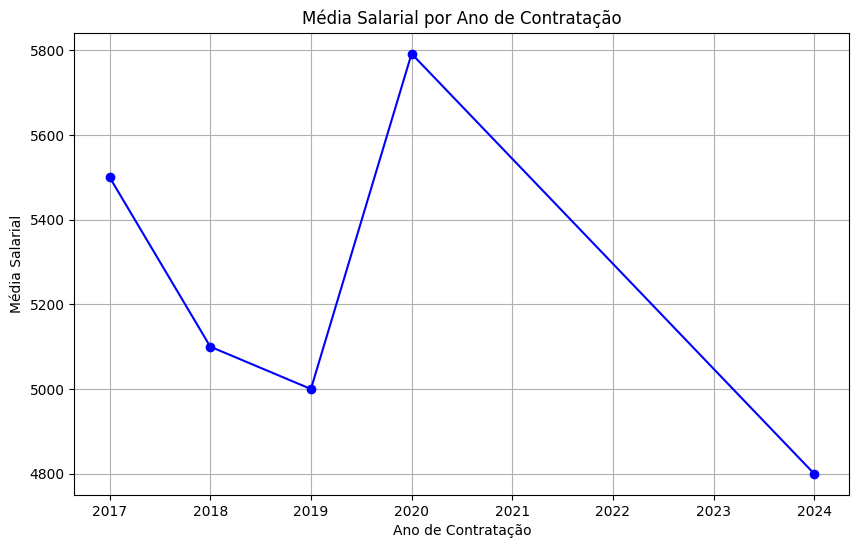

In [1508]:
#31. Comparação de Salários por Período de Contratação: Comparar os salários de funcionários contratados em diferentes anos para identificar tendências de aumento salarial.
# Agrupar por ano de contratação e calcular a média salarial
df_media_salarial_por_ano = df_cleaned.groupBy("Ano de Contratação").agg(
    avg("Salario").alias("Media_Salarial"))

# Ordenar por ano de contratação
df_media_salarial_por_ano = df_media_salarial_por_ano.orderBy("Ano de Contratação")

# Mostrar o resultado
df_media_salarial_por_ano.show()

# Coletar dados para visualização
anos = [row['Ano de Contratação'] for row in df_media_salarial_por_ano.collect()]
salarios = [row['Media_Salarial'] for row in df_media_salarial_por_ano.collect()]

# Criar o gráfico
plt.figure(figsize=(10, 6))
plt.plot(anos, salarios, marker='o', linestyle='-', color='b')
plt.title('Média Salarial por Ano de Contratação')
plt.xlabel('Ano de Contratação')
plt.ylabel('Média Salarial')
plt.grid(True)
plt.show()

In [1509]:
#32. Criação de Coluna de Faixa Etária: Agrupar os funcionários em faixas etárias (e.g., 20-30 anos, 31-40 anos) e analisar diferenças entre elas.

# Definir as faixas etárias e criar a coluna 'Faixa Etaria'
df_cleaned = df_cleaned.withColumn(
    "Faixa Etaria",
    when(col("Idade") <= 30, "20-30 anos")
    .when((col("Idade") > 30) & (col("Idade") <= 40), "31-40 anos")
    .when((col("Idade") > 40) & (col("Idade") <= 50), "41-50 anos")
    .otherwise("51+ anos"))

# Mostrar o DataFrame com a nova coluna
df_cleaned.show()

# Agrupar por faixa etária calcular a média salarial e contar o número de funcionários
df_media_sal_etaria = df_cleaned.groupBy("Faixa Etaria",).agg(
    avg("Salario").alias("Media_Salarial"))

df_num_faixa_etaria = df_cleaned.groupBy("Faixa Etaria").agg(
    count("ID").alias("Numero_Funcionarios"))

#Juntando as infomações em um unico lugar
df_combined = df_media_sal_etaria.join(df_num_faixa_etaria,on="Faixa Etaria",how="inner").show()

+------------+---+--------------+-----+-----------------+-------------------+-----------------+------+-----------------+----------------+------------------+-----------------+------------+-------------+--------------------------+------------------+---------+--------------------+------------------+----------------+------------------+------------------+------------+
|        Area| ID|          Nome|Idade|          Salario|Data de Contratação|Status de Emprego|    Q1|               Q3|             IQR|   Limite Inferior|  Limite Superior|Dias de Casa|Tempo de Casa|Categoria De Tempo de Casa|Ano de Contratação|   Genero|Idade na Contratação|         anos_casa|Salario Anterior|Diferença Salarial|Mês de Contratação|Faixa Etaria|
+------------+---+--------------+-----+-----------------+-------------------+-----------------+------+-----------------+----------------+------------------+-----------------+------------+-------------+--------------------------+------------------+---------+-----------

In [1510]:
#33. Relação Entre Área e Tempo de Contratação: Identificar se alguns departamentos tendem a manter seus funcionários por mais tempo do que outros.
# Calcular o tempo de casa em anos
df_cleaned = df_cleaned.withColumn(
    "Tempo de Casa (Anos)",
    datediff(current_date(), col("Data de Contratação")) / 365)

# Calcular a média do tempo de casa por área
df_tempo_medio_area = df_cleaned.groupBy("Area").agg(
    avg("Tempo de Casa (Anos)").alias("Media_Tempo_Casa"))

# Mostrar o DataFrame resultante
df_tempo_medio_area.show()

+------------+------------------+
|        Area|  Media_Tempo_Casa|
+------------+------------------+
|desconhecido| 6.778082191780822|
|  financeiro| 4.592465753424658|
|   marketing| 6.398630136986301|
|          rh|3.2611872146118723|
+------------+------------------+



In [1511]:
#34. Previsão de Turnover: Usar dados históricos para prever quais funcionários têm maior probabilidade de deixar a empresa.
from pyspark.sql.functions import col, when, avg
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Verificar se df_cleaned não é None e contém dados
if df_cleaned is not None and df_cleaned.count() > 0:
    # Calcular a média do salário
    mean_salary = df_cleaned.select(avg("Salario")).collect()[0][0]
    print(f"Média do Salário: {mean_salary}")

    # Tratar valores ausentes no salário
    df_cleaned = df_cleaned.withColumn("Salario", when(col("Salario").isNull(), mean_salary).otherwise(col("Salario")))

    # Criar variável de turnover (0 = Não saiu, 1 = Saiu)
    df_cleaned = df_cleaned.withColumn("Turnover", when(col("Status de Emprego") == "inativo", 1).otherwise(0))

    # Selecionar recursos e target
    features = ["Idade", "Salario", "Tempo de Casa", "Ano de Contratação"]
    target = "Turnover"

    # Criar um vetor de características
    assembler = VectorAssembler(inputCols=features, outputCol="features")
    df_assembled = assembler.transform(df_cleaned)

    # Dividir os dados
    train_data, test_data = df_assembled.randomSplit([0.8, 0.2], seed=1234)

    # Criar e treinar o modelo
    lr = LogisticRegression(featuresCol="features", labelCol=target)
    lr_model = lr.fit(train_data)

    # Fazer previsões
    predictions = lr_model.transform(test_data)

    # Avaliar o modelo
    evaluator = BinaryClassificationEvaluator(labelCol=target)
    accuracy = evaluator.evaluate(predictions)
    print(f"Accuracy: {accuracy:.2f}")

    # Exibir coeficientes do modelo
    print("Coefficients:", lr_model.coefficients)
    print("Intercept:", lr_model.intercept)

    # Novos dados de exemplo
    new_data = spark.createDataFrame([
        (30, 5000, 5, 2021),
        (40, 6000, 8, 2019)
    ], features)

    # Transformar e prever
    new_data_assembled = assembler.transform(new_data)
    predictions = lr_model.transform(new_data_assembled)
    predictions.select("prediction", "probability").show()
else:
    print("O DataFrame df_cleaned não está corretamente definido ou está vazio.")


Média do Salário: 5366.666666666666
Accuracy: 1.00
Coefficients: [10.629419950045767,-0.0016027366118444074,2.1817617527882573,4.4034905575597545]
Intercept: -9232.86944048826
+----------+--------------------+
|prediction|         probability|
+----------+--------------------+
|       0.0|[0.99999116958269...|
|       1.0|[3.70964484084977...|
+----------+--------------------+



In [1512]:
# Exportar para CSV
#df_cleaned.write.csv("salario_maximo_minimo_por_departamento.csv", header=True)